In [1]:
import os

print(os.getcwd())
os.chdir("../../")
os.getcwd()

/data01/dl23vitcas/dl_project/src/single_task_object_detection


'/data01/dl23vitcas/dl_project'

In [2]:
import sys
import argparse
import os

sys.argv = ["view", "--config", "config/single_task_object_detection.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

config/single_task_object_detection.yaml


In [3]:
import torch
from torchvision.transforms import transforms
from config_experiments import config
from dataloader import VOC08Attr
from utils import get_indices_batch

device = "cuda"
from bbox_transform import (
    relative_to_absolute_bbox,
    absolute_to_relative_bbox,
    apply_nms,
)

In [4]:
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import numpy as np


def show(imgs):
    plt.rcParams["savefig.bbox"] = "tight"
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)  # (H, W)
        axs[0, i].imshow(np.asarray(img))  # (W, H, 3)
        # axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) # uncomment to remove axis in plot


def show_bounding_box(img_tensor, box, labels=None, color="white"):
    img_tensor = inverse_transform(img_tensor)
    show(draw_bounding_boxes(img_tensor, box, colors=color, labels=labels, width=1))


def show_bbox_with_transform(img, box, mean, std, labels=None, color="white"):
    img = inverse_transorm_with_normalize(img, mean, std)
    show(draw_bounding_boxes(img, box, colors=color, labels=labels, width=2))


def inverse_transorm_with_normalize(image, mean, std):
    image = np.array(image)
    for channel in range(3):
        image[channel] = image[channel] * std[channel] + mean[channel]
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    return image


def inverse_transform(image):
    image = np.array(image)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    image = torch.from_numpy(image)
    return image

In [5]:
from model import ObjectDetectionModel

model_path = "models/object_detection/model_2024-06-08_11-19.pth"
model = ObjectDetectionModel().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [6]:
transform_val = transforms.Compose(
    [
        transforms.Resize(size=config["transform"]["resize_values"]),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)
# dataset & dataloader

val_data = VOC08Attr(train=False, transform=transform_val)

ground truth
tensor([[159.0000,  51.0000, 430.0000, 375.0000]], device='cuda:0')
tensor([2], device='cuda:0')
['person']
prediction
tensor([[125.3316,  53.4243, 424.7445, 373.2922],
        [170.8617, 222.4410, 488.4232, 368.5132]], device='cuda:0')
['person', 'chair']
tensor([0.9945, 0.6106], device='cuda:0')


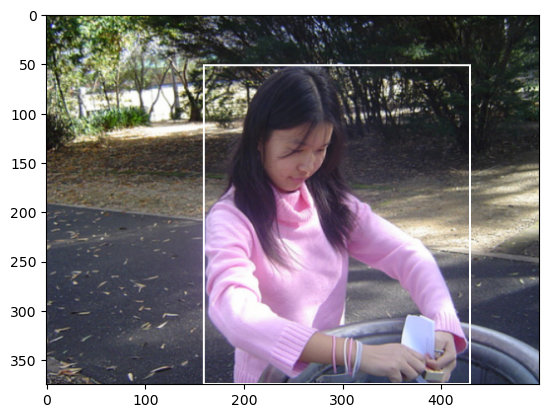

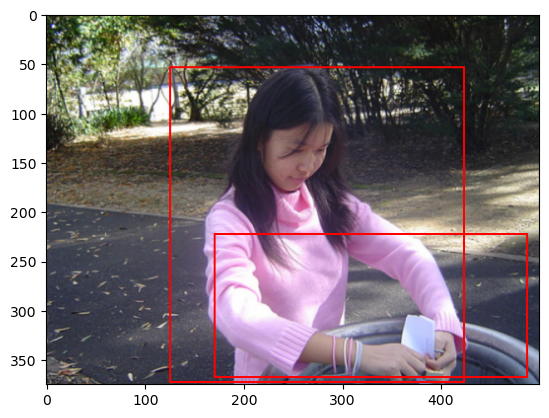

In [84]:
i = 100
model.eval()

with torch.no_grad():
    image, image_size, gt_class, gt_bbox, gt_attributes, ss_rois = val_data[i]
    image = image.unsqueeze(0).to(device)
    gt_class = gt_class.to(device)
    gt_bbox = gt_bbox.to(device)
    ss_rois = ss_rois.to(device)
    gt_bbox = relative_to_absolute_bbox(gt_bbox, image_size)
    ss_rois = relative_to_absolute_bbox(ss_rois, config["transform"]["resize_values"])

    indices_batch = get_indices_batch(image.shape[0], ss_rois.shape[0]).unsqueeze(-1)

    indices_batch = indices_batch.to(device)

    cls_max_score, max_score, bboxs = model.prediction_img(
        image, ss_rois, indices_batch
    )

    bboxs = absolute_to_relative_bbox(bboxs, config["transform"]["resize_values"])
    bboxs = relative_to_absolute_bbox(bboxs, image_size)

    pred_bbox, pred_class, pred_score = apply_nms(cls_max_score, max_score, bboxs)

image = transforms.Resize(image_size[::-1], antialias=True)(image.squeeze(0))
print("ground truth")

print(gt_bbox)
print(gt_class)

print([val_data.id2category[classe.item()] for classe in gt_class])
print("prediction")
print(pred_bbox)
print([val_data.id2category[classe.item()] for classe in pred_class])

print(pred_score)
show_bbox_with_transform(
    image.cpu(),
    gt_bbox.cpu(),
    mean=config["transform"]["mean"],
    std=config["transform"]["std"],
)

show_bbox_with_transform(
    image.cpu(),
    pred_bbox.cpu(),
    mean=config["transform"]["mean"],
    std=config["transform"]["std"],
    color="red",
)